In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy.ndimage import uniform_filter1d  # For smoothing

# Define the base directory and experiment names
base_dir = "results/State-Vis-Pretraining/MiniGrid/DistShift2-v0"
# COMP EXP: "PPO_AE_Offline_NO_Freeze", "PPO_AE_Offline_CNN_Freeze", "PPO_IMDP_Offline_CNN_Part_Freeze", "PPO_IMDP_Offline_Freeze", "PPO_AEGIS_ALT1_1E", "PPO_AEGIS_5E6", "PPO_AEGIS_TCL"

# OFFLINE
# DATA EXP: "PPO_LMDP_Offline", "PPO_LMDP_Offline", "PPO_LMDP_Offline_5E6", "PPO_LMDP_Offline_25e5", "PPO_LMDP_Offline_10e5", "PPO_LMDP_Offline_5E5", "PPO_LMDP_Offline_5E4", "PPO_LMDP_Offline_5E3"
# EPOCHS EXP: "PPO_LMDP_Offline_5E5_10", "PPO_LMDP_Offline_5E5_20", "PPO_LMDP_Offline_5E5_50", "PPO_LMDP_Offline_5E5_100", "PPO_LMDP_Offline_5E5_200"

# BUFFER EXP: "PPO_AEGIS_Buffer_64", "PPO_AEGIS_Buffer_128", "PPO_AEGIS_Buffer_256", "PPO_AEGIS_Buffer_512", "PPO_AEGIS_Buffer_1024", "PPO_AEGIS_ALT1_1E", "PPO_AEGIS_5E6", "PPO_AEGIS_TCL" 
# "PPO_LMDP_Offline_5E5",  "PPO_AEGIS_ALT1_1E", "PPO_AEGIS_5E6", "PPO_AEGIS_TCL",
experiments =  ["PPO_Vanilla", "PPO_LMDP_Offline"
                "PPO_AEGIS",
                ]

# Define the number of seeds
num_seeds = 10

# Initialize dictionaries to store data
episode_rewards = {exp: [] for exp in experiments}
episode_lengths = {exp: [] for exp in experiments}
steps = {exp: [] for exp in experiments}  # To store step numbers

# Read data from CSV files
for exp in experiments:
    for seed in range(1, num_seeds + 1):
        file_path = os.path.join(base_dir, exp, f"seed-{seed}", "train.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            episode_rewards[exp].append(df['true_episode_reward'])
            episode_lengths[exp].append(df['episode_length'])
            steps[exp].append(df['step'].values)  # Read step numbers
        else:
            print(f"File not found: {file_path}")

# Align data to the length of the longest seed for each experiment
def align_data(data):
    max_length = max(len(seed_data) for seed_data in data)
    aligned_data = []
    for seed_data in data:
        if len(seed_data) < max_length:
            # Repeat the last value to match the length of the longest seed
            aligned_data.append(np.pad(seed_data, (0, max_length - len(seed_data)), mode='edge'))
        else:
            aligned_data.append(seed_data)
    return np.array(aligned_data)

aligned_episode_rewards = {exp: align_data(episode_rewards[exp]) for exp in experiments}
aligned_episode_lengths = {exp: align_data(episode_lengths[exp]) for exp in experiments}
aligned_steps = {exp: align_data(steps[exp]) for exp in experiments}

# Compute mean and standard error for each experiment
def compute_stats(data):
    mean = np.mean(data, axis=0)
    std_error = sem(data, axis=0)
    return mean, std_error

def find_closest_index_np(sorted_array, x):
    sorted_array = np.asarray(sorted_array)
    idx = np.searchsorted(sorted_array, x, side="left")
    
    if idx > 0 and (idx == len(sorted_array) or 
                    np.abs(x - sorted_array[idx-1]) <= np.abs(x - sorted_array[idx])):
        return idx - 1
    else:
        return idx
    
episode_rewards_stats = {exp: compute_stats(aligned_episode_rewards[exp]) for exp in experiments}
episode_lengths_stats = {exp: compute_stats(aligned_episode_lengths[exp]) for exp in experiments}
steps_stats = {exp: compute_stats(aligned_steps[exp]) for exp in experiments}

# Smoothing function using a moving average
def smooth_data(data, window_size=10):
    """Apply a moving average to smooth the data."""
    return uniform_filter1d(data, size=window_size, mode='nearest')

# Plotting function
def plot_results(stats, steps_stats, ylabel, title, filename, window_size=10):
    plt.figure(figsize=(12, 6))
    for exp in experiments:
        mean, std_error = stats[exp]
        step_mean, _ = steps_stats[exp]  # Use step numbers for the x-axis

        # Smooth the mean and std_error
        smoothed_mean = smooth_data(mean, window_size)
        smoothed_std_error = smooth_data(std_error, window_size)

        k100 = find_closest_index_np(step_mean, 100000)
        k50 = find_closest_index_np(step_mean, 50000)

        print(f'{exp}: at {step_mean[k50]}: {smoothed_mean[k50]}, at {step_mean[k100]}: {smoothed_mean[k100]}, max:{max(smoothed_mean)}')
        
        plt.plot(step_mean, smoothed_mean, label=exp)
        plt.fill_between(step_mean, smoothed_mean - smoothed_std_error, smoothed_mean + smoothed_std_error, alpha=0.2)
    plt.xlabel('Step')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename+".png")
    plt.show()


PPO_Vanilla: at 49968.6: 0.11747999999999999, at 100013.7: 0.5512699999999998, max:0.6214949999999997
PPO_AEGIS: at 49983.8: 0.11418999999999997, at 99996.9: 0.7710300000000007, max:0.8695000000000055


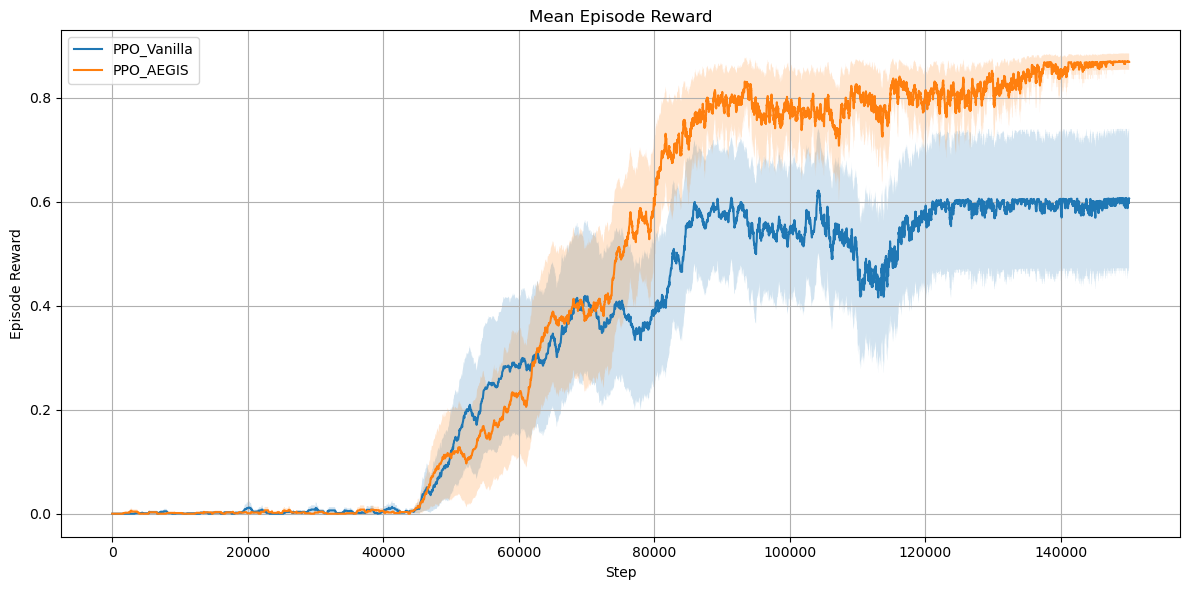

In [3]:
# Plot episode rewards
plot_results(episode_rewards_stats, steps_stats, 
             'Episode Reward', 'Mean Episode Reward', 
             filename="plot_episode_reward", window_size=20)

PPO_VanillaGPU: at 52580.3: 43.724, at 100k: 33.200000000000095, max:99.17200000000004
PPO_LMDP_Offline_5E6: at 49919.4: 40.489999999999895, at 100k: 22.302000000000092, max:99.76799999999999
PPO_LMDP_Offline_25e5: at 45215.1: 56.03400000000011, at 100k: 23.78800000000017, max:99.75599999999999
PPO_LMDP_Offline_10e5: at 50024.2: 33.31800000000001, at 100k: 25.308000000000135, max:99.62400000000001
PPO_LMDP_Offline_5E5: at 39637.2: 18.936000000000053, at 100k: 14.799999999999994, max:99.38600000000001
PPO_LMDP_Offline_5E4: at 46652.5: 28.18399999999996, at 100k: 21.100000000000012, max:99.54799999999999
PPO_LMDP_Offline_5E3: at 51313.0: 26.72799999999998, at 100k: 18.227999999999962, max:99.53599999999999


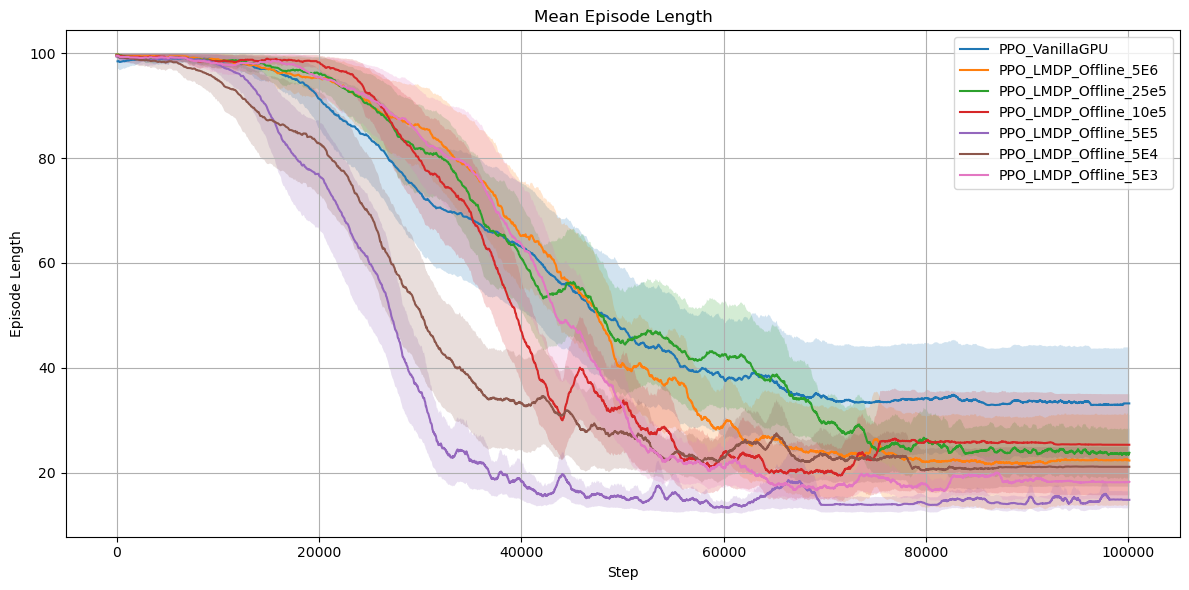

In [3]:
# Plot episode lengths
plot_results(episode_lengths_stats, steps_stats, 
             'Episode Length', 'Mean Episode Length', 
             filename="plot_episode_length", window_size=50)